In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle as pkl
from scipy.spatial.distance import cdist
from tqdm import tqdm
import numpy as np
from pathlib import Path

from scipy.interpolate import splrep, BSpline
from scipy.signal import savgol_filter
from pysep.atm.utils import load_new_style
from dataclasses import dataclass
from collections import namedtuple
import matplotlib

In [16]:
@dataclass
class colorscheme:
    DartmouthGreen : str = "#00693E"
    ForestGreen : str = "#12312B"
    RichForestGreen : str = "#0D1E1C"
    White : str = "#FFFFFF"
    Black : str = "#000000"
    AutumBrown : str = "#643C20"
    BonfireRed : str = "#9D162E"
    SpringGreen : str = "#C4DD88"
    Violet : str = "#B607DE"
    
    pallet = namedtuple("pallet", "C0 C1")
    primary : namedtuple = pallet(DartmouthGreen, Black)
    seconday : namedtuple = pallet(ForestGreen,AutumBrown)
    tertiery : namedtuple = pallet(RichForestGreen,BonfireRed)
DGcmap =cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#FFFFFF", colorscheme.DartmouthGreen])

In [6]:
PHOTROOT = "/mnt/Astronomy/GraduateSchool/Thesis/GCConsistency/NGC2808/photometry/HUGS/ngc2808/photometry.pkl"

In [3]:
def normalize_density(color, mag, density, n=5000):
    normDensity = np.zeros(shape=color.shape[0])
    for IDx, (c, m, d) in tqdm(enumerate(zip(color, mag, density)), total=len(density)):
        distances = cdist(np.array([[c, m]]), np.array([color, mag]).T)[0]
        closestIDX= np.argpartition(distances, n)
        closestDensity = density[closestIDX[:n]]
        meanNearDensity = np.mean(closestDensity)
        normalizedDensity = d/meanNearDensity
        normDensity[IDx] = normalizedDensity
    return normDensity
def normalize_density_magBin(color, mag, density, binSize=0.1):
    normDensity = np.zeros(shape=color.shape[0])
    for IDx, (c, m, d) in tqdm(enumerate(zip(color, mag, density)), total=len(density)):
        cut = (mag > m-binSize/2) & (mag <= m+binSize/2)
        binDensity = density[cut]
        meanBinDensity = np.mean(binDensity)
        normalizedDensity = d/meanBinDensity
        normDensity[IDx] = normalizedDensity
    return normDensity

In [4]:
densityCache = "/mnt/Astronomy/packages/localTests/fidanka/MC_1_Density.npz"
assert os.path.exists(densityCache), "Density Cache File not Found!" 

In [7]:
density = np.load(densityCache)['density']
with open(PHOTROOT, 'rb') as f:
    HUGSPhotometry = pkl.load(f)[1]
color = HUGSPhotometry["F275W"] - HUGSPhotometry["F814W"]
mag = HUGSPhotometry["F814W"]
HUGSPhotometry['density'] = normalize_density_magBin(color, mag, density, binSize=0.3)

100%|████████████████████████████████████████████████████████| 38319/38319 [00:15<00:00, 2483.52it/s]


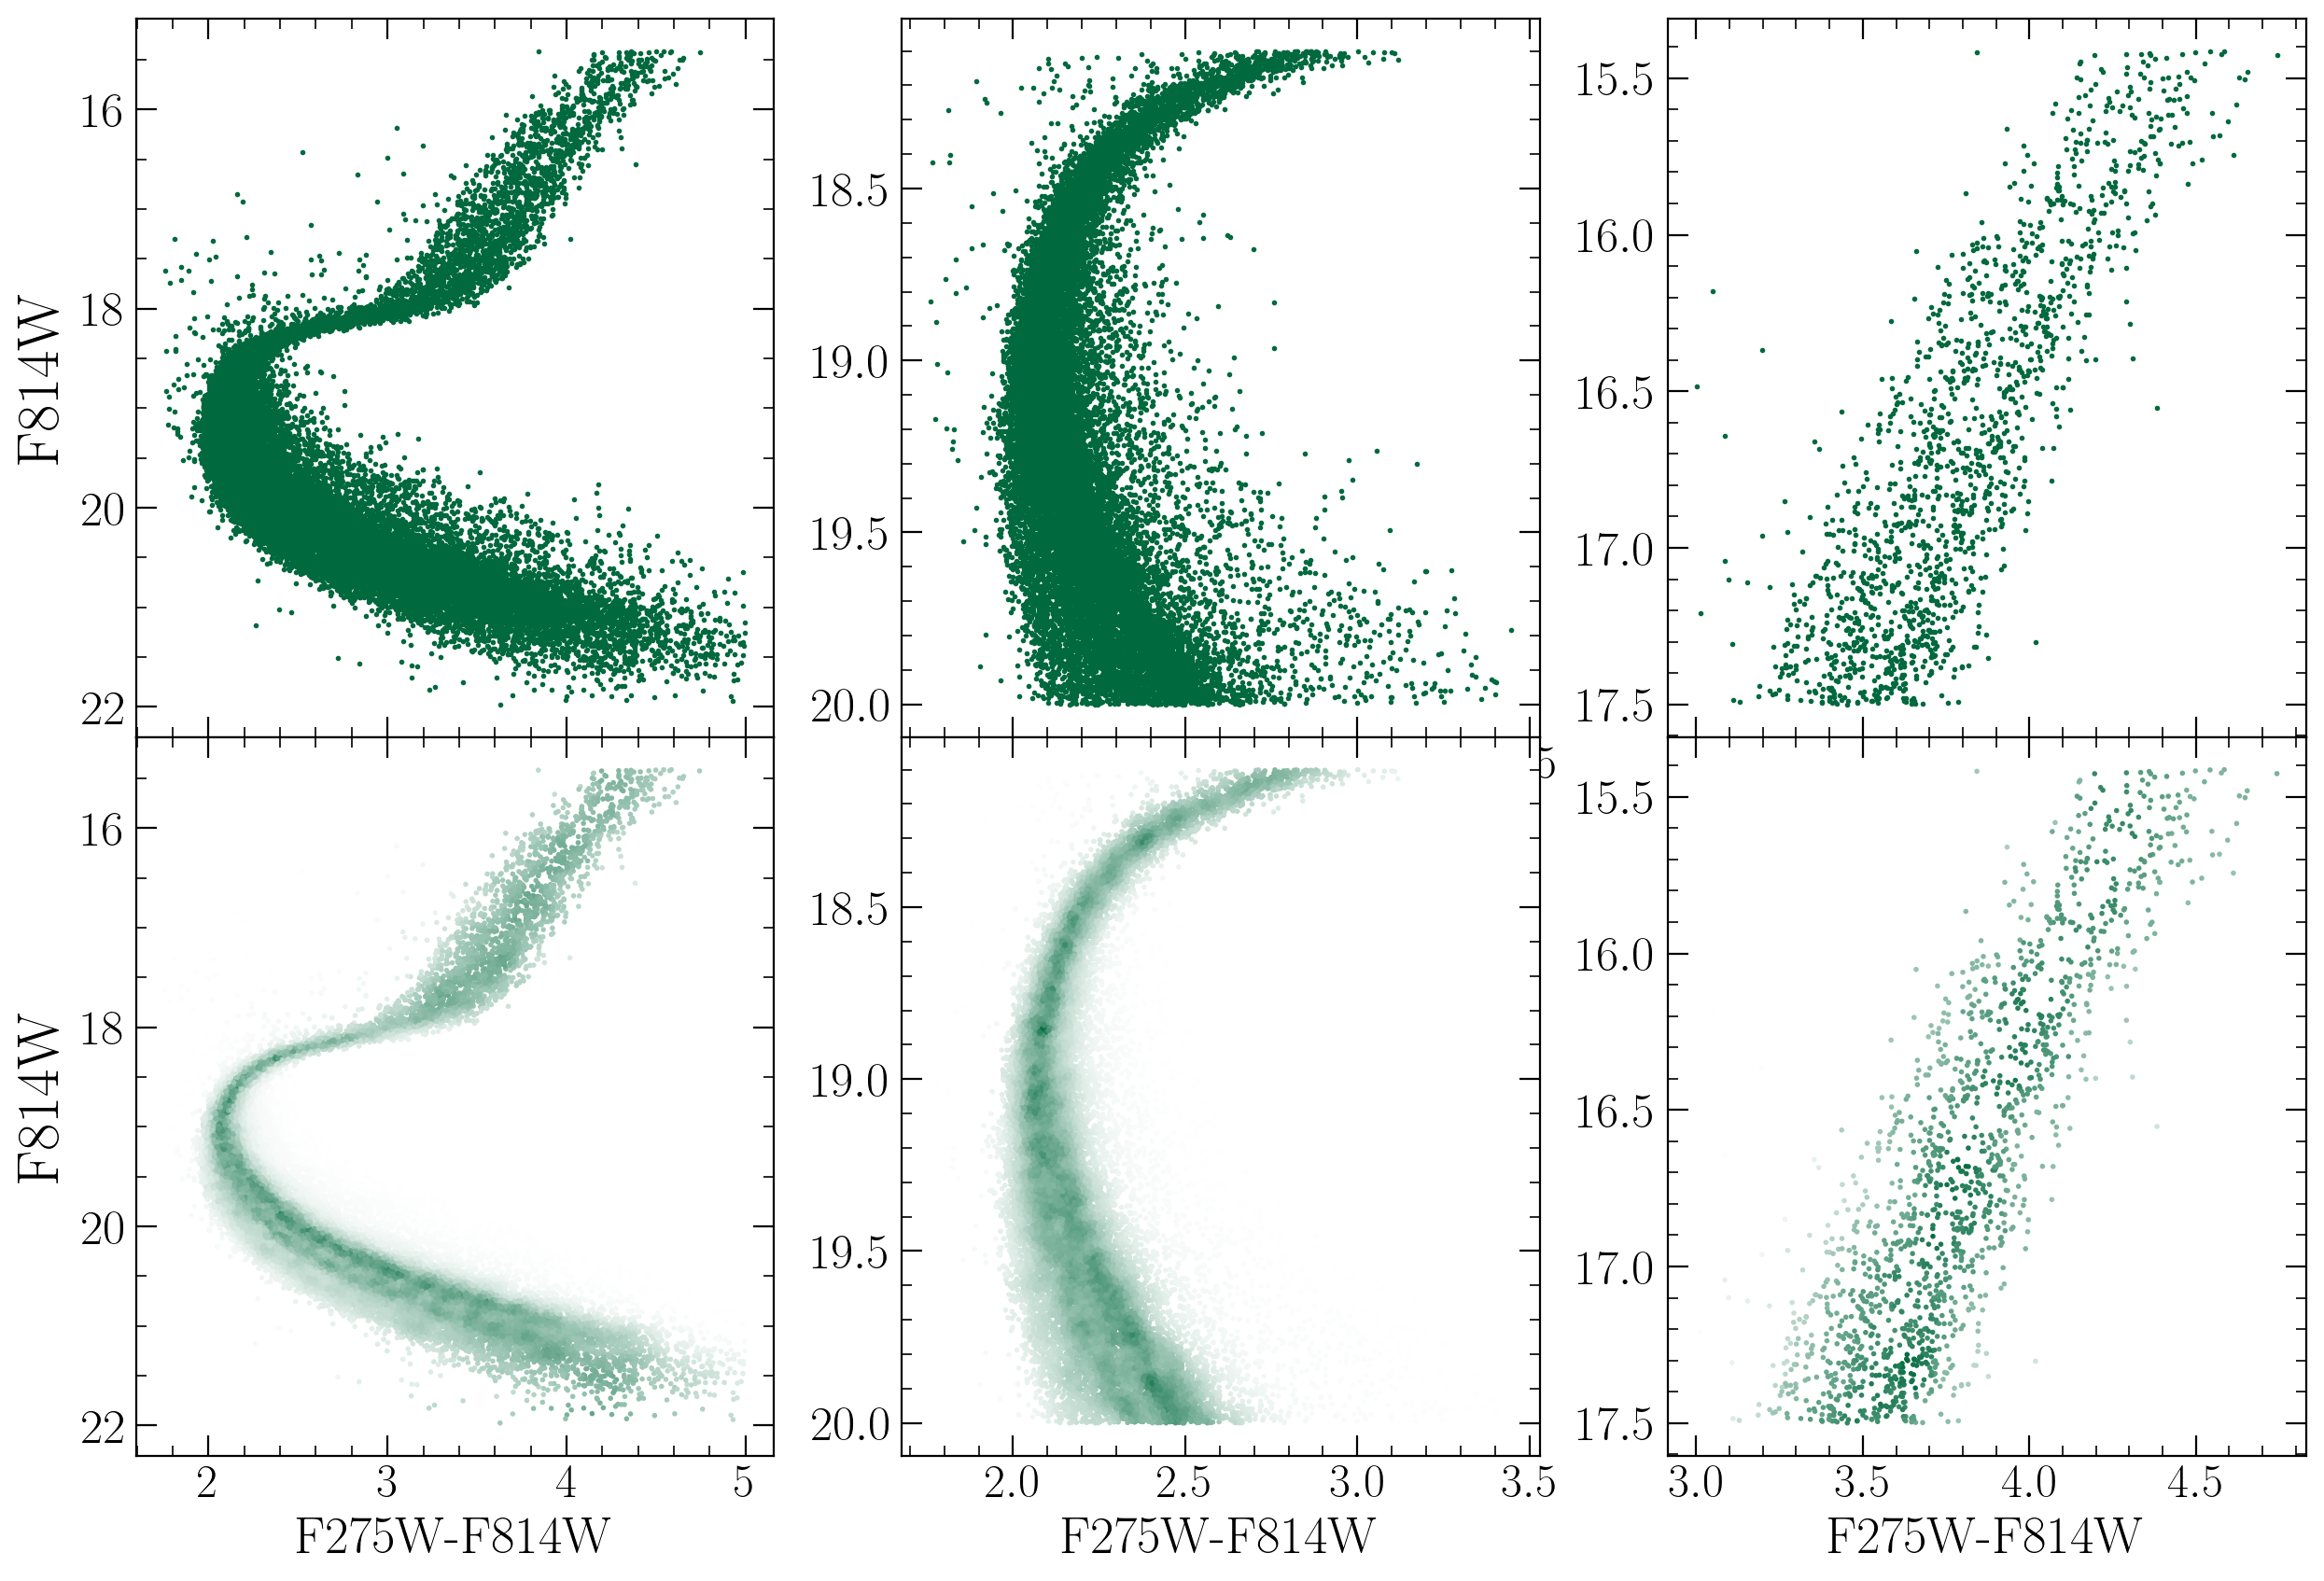

In [20]:
with plt.style.context(pubStyle):
    fig, axs = plt.subplots(2,3, figsize=(15, 10))

    ax1 = axs[0,0]
    ax2 = axs[1,0]
    ax3 = axs[0,1]
    ax4 = axs[1,1]
    ax5 = axs[0,2]
    ax6 = axs[1,2]
    
    f1 = "F275W"
    f2 = "F814W"
    f3 = f2
    color = HUGSPhotometry[f1]-HUGSPhotometry[f2]
    mag = HUGSPhotometry[f3]
    density = HUGSPhotometry["density"]
    
    condF = (color > 1.75) & (color < 5) & (mag < 22) & (mag > 15)
    colorF = color[condF]
    magF = mag[condF]
    densityF = density[condF]

    ax1.scatter(colorF, magF, s=1, c=colorscheme.DartmouthGreen)
    ax1.invert_yaxis()

    ax2.scatter(colorF, magF, s=1, c=densityF, cmap=DGcmap)
    ax2.invert_yaxis()
    
    condZ = (color > 1.75) & (color < 3.5) & (mag < 20) & (mag > 18.1)
    colorZ = color[condZ]
    magZ = mag[condZ]
    densityZ = density[condZ]
    
    ax3.scatter(colorZ, magZ, s=1, c=colorscheme.DartmouthGreen)
    ax3.invert_yaxis()
    
    # normDensityZ = normalize_density(colorZ, magZ, densityZ)
    ax4.scatter(colorZ, magZ, s=1, c=densityZ, alpha=1, cmap=DGcmap)
    ax4.invert_yaxis()
    
    # IDs = ["A", "B", "C", "D", "E", "F"]
    # Axs = [ax1, ax3, ax5, ax2, ax4, ax6]
    # for ax, l in zip(Axs, IDs):
    #     ax.text(0.9, 0.5, l, transform=ax.transAxes)
    
    plt.subplots_adjust(hspace=0)
    
    ax1.set_ylabel(f"{f3}", fontsize=23)
    ax2.set_ylabel(f"{f3}", fontsize=23)
    # ax3.set_ylabel(f"{f3}", fontsize=23)
    # ax4.set_ylabel(f"{f3}", fontsize=23)
    
    ax2.set_xlabel(f"{f1}-{f2}")
    ax4.set_xlabel(f"{f1}-{f2}")
    ax6.set_xlabel(f"{f1}-{f2}")
    
    condRGB = (color > 3) & (color < 5) & (mag < 17.5) & (mag > 15)
    colorRGB = color[condRGB]
    magRGB = mag[condRGB]
    densityRGB = density[condRGB]
    # normDensity = normalize_density(colorRGB, magRGB, densityRGB, n=10)
    ax5.scatter(colorRGB, magRGB,s=1, c=colorscheme.DartmouthGreen)
    ax5.invert_yaxis()
    ax6.scatter(colorRGB, magRGB,s=1, c=densityRGB, cmap=DGcmap)
    ax6.invert_yaxis()
    
    fig.savefig("Figures/DensityMap.png", dpi=300)